# 2024 Fantasy Point Predictions


In [12]:
# data science stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# data preprocessing, performance metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

# display
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

# drew brees
random_state = 9

In [13]:
# load data
df = pd.read_csv('./data/final_data/master.csv')

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

# view
print(f'The data has {df["Key"].nunique()} unique players, with {df.shape[0]} rows and {df.shape[1]} columns:')
df.head()

The data has 6959 unique players, with 29425 rows and 203 columns:


,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Key,Year,Scrim_Yds,Scrim_TD,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,Pass_Y/A,Touches,Cmp%,Catch%,Pass_Cmp_per_game,Pass_Att_per_game,Pass_Yds_per_game,Pass_TD_per_game,Pass_Int_per_game,Rush_Att_per_game,Rush_Yds_per_game,Rush_TD_per_game,Rec_Tgt_per_game,Rec_Rec_per_game,Rec_Yds_per_game,Rec_TD_per_game,Fmb_per_game,FmbLost_per_game,Scrim_Yds_per_game,Scrim_TD_per_game,Touches_per_game,Points_standard,Points_half-ppr,Points_ppr,Points_6,PPG_standard,PPG_half-ppr,PPG_ppr,PPG_6,PPT_standard,PPT_half-ppr,PPT_ppr,PPT_6,SeasonOvrRank_standard,SeasonOvrRank_half-ppr,SeasonOvrRank_ppr,SeasonOvrRank_6,SeasonPosRank_standard,SeasonPosRank_half-ppr,SeasonPosRank_ppr,SeasonPosRank_6,PPGOvrRank_standard,PPGOvrRank_half-ppr,PPGOvrRank_ppr,PPGOvrRank_6,PPGPosRank_standard,PPGPosRank_half-ppr,PPGPosRank_ppr,PPGPosRank_6,PPTOvrRank_standard,PPTOvrRank_half-ppr,PPTOvrRank_ppr,PPTOvrRank_6,PPTPosRank_standard,PPTPosRank_half-ppr,PPTPosRank_ppr,PPTPosRank_6,Points_VORP_standard_10tm,Points_VORP_half-ppr_10tm,Points_VORP_ppr_10tm,Points_VORP_6_10tm,PPG_VORP_standard_10tm,PPG_VORP_half-ppr_10tm,PPG_VORP_ppr_10tm,PPG_VORP_6_10tm,Points_VORP_standard_12tm,Points_VORP_half-ppr_12tm,Points_VORP_ppr_12tm,Points_VORP_6_12tm,PPG_VORP_standard_12tm,PPG_VORP_half-ppr_12tm,PPG_VORP_ppr_12tm,PPG_VORP_6_12tm,Points_VORP_standard_10tm_3WR,Points_VORP_half-ppr_10tm_3WR,Points_VORP_ppr_10tm_3WR,Points_VORP_6_10tm_3WR,PPG_VORP_standard_10tm_3WR,PPG_VORP_half-ppr_10tm_3WR,PPG_VORP_ppr_10tm_3WR,PPG_VORP_6_10tm_3WR,Points_VORP_standard_12tm_3WR,Points_VORP_half-ppr_12tm_3WR,Points_VORP_ppr_12tm_3WR,Points_VORP_6_12tm_3WR,PPG_VORP_standard_12tm_3WR,PPG_VORP_half-ppr_12tm_3WR,PPG_VORP_ppr_12tm_3WR,PPG_VORP_6_12tm_3WR,SeasonTarget_standard,SeasonTarget_half-ppr,SeasonTarget_ppr,SeasonTarget_6,PPGTarget_standard,PPGTarget_half-ppr,PPGTarget_ppr,PPGTarget_6,Pass_accuracy_percent,Pass_avg_depth_of_target,Pass_avg_time_to_throw,Pass_dropbacks,Pass_grades_pass,Pass_passing_snaps,Pass_Dropback%,Pass_Aimed_passes%,Pass_Dropped_passes%,Pass_Batted_passes%,Pass_Thrown_away%,Pass_Pressure%,Pass_Scramble%,Pass_Sack%,Pass_Pressure_to_sack%,Pass_BTT%,Pass_TWP%,Pass_First_down%,Rush_elusive_rating,Rush_grades_hands_fumble,Rush_grades_offense,Rush_grades_run,Rush_longest,Rush_Team_Rush%,Rush_Avoided_tackles_per_attempt,Rush_10+_yard_run%,Rush_15+_yard_run%,Rush_15+_yard_run_yards%,Rush_First_down%,Rush_Gap%,Rush_Zone%,Rush_YCO_per_attempt,Receiving_avg_depth_of_target,Receiving_caught_percent,Receiving_contested_catch_rate,Receiving_drop_rate,Receiving_grades_hands_drop,Receiving_grades_hands_fumble,Receiving_grades_offense,Receiving_grades_pass_route,Receiving_inline_rate,Receiving_interceptions,Receiving_longest,Receiving_pass_block_rate,Receiving_route_rate,Receiving_slot_rate,Receiving_targeted_qb_rating,Receiving_wide_rate,Receiving_yards_after_catch_per_reception,Receiving_yards_per_reception,Receiving_yprr,Receiving_Avoided_tackles_per_reception,Receiving_First_down%,Receiving_Int_per_target,Receiving_YAC%,Team_Team Grade,Team_Offense Grade,Team_Passing Grade,Team_Pass Blocking Grade,Team_Receiving Grade,Team_Rushing Grade,Team_Run Blocking Grade,Team_Defense Grade,Team_Run Defense Grade,Team_Tackling Grade,Team_Pass Rush Grade,Team_Coverage Grade,Team_Special Teams Grade,Team_Wins,Team_Losses,Team_PPG,Team_PPG_allowed,Team_Pass Defense Grade,Team_Win%
0,Israel Abanikanda,NYJ,RB,21,6,0,0,0,0,0,0,22,70,3.181818,0,11.0,7,43,6.142857,0,1.0,1.0,AbanIs00,2023,113,0,17,0.352941,0.0000,False,False,0,0.0,29,0.0,0.636364,0.0,0.0,0.0,0.0,0.0,3.666667,11.666667,0.000,1.833333,1.166667,7.166667,0.0000,0.166667,0.166667,18.833333,0.0000,4.833333,9.3,12.8,16.3,16.3,1.550000,2.133333,2.716667,2.716667,0.320690,0.441379,0.562069,0.562069,412.0,400.0,394.0,398.0,105.0,99.0,97.0,97.0,347.0,342.0,334.0,336.0,93.0,90.0,8

In [14]:
# drop rows prior to 2006
df = df[df['Year'] >= 2006]

# drop 2024 rows
players_2024 = df[df['Year'] == 2024]
df = df[df['Year'] != 2024]

# check
print(f'The data now has {df["Key"].nunique()} unique players, with {df.shape[0]} rows and {df.shape[1]} columns:')

The data now has 2890 unique players, with 10930 rows and 203 columns:


## Create Features
Career (total) and Recent

- Volume
- Production (per touch)
- Missed games (to estimate injury risk)

We will create features using 3 types of stats:

__Cumulative__:
- A running total of a player's stats over time.
- This accumulates a player's career totals to capture how good they've been over their entire career.

__Rolling__:
- An average of a player's stats over a specified number of recent seasons, which updates as new data comes in.
- This captures a player's performance in the last n seasons (I will use 2 and 4 seasons).

__Year-over-Year__:
- The change in a player's stats from one season to the next.
- This tells us how a player was trending in their most recent season.

In [73]:
# now, we'll drop some columns that are not needed
df = df.drop(columns=['Tm', 'OvrRank_6', 'PosRank_6', 'VORP_6'])

# turn 'Pos' column into 4 categorical columns
df = pd.get_dummies(df, columns=['Pos'])

In [74]:
# add target col
df['Target'] = df.groupby('Key')['Points_6'].shift(-1)

# check
df[df['Player'] == 'Josh Allen'][['Player', 'Year', 'Exp', 'Points_shady', 'Target']]

,Player,Year,Exp,Points_shady,Target
307,Josh Allen,2018,0,238.06,331.56
308,Josh Allen,2019,1,331.56,480.06
309,Josh Allen,2020,2,480.06,483.58
310,Josh Allen,2021,3,483.58,475.52
311,Josh Allen,2022,4,475.52,462.64
312,Josh Allen,2023,5,462.64,NaN


In [6]:
# column lists
id_cols = ['Key', 'Player', 'Year']
metadata_cols = ['Pos_QB', 'Pos_RB', 'Pos_TE', 'Pos_WR', 'Age', 'Exp', 'AllPro']
aggregated_cols = ['Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rec_Tgt', 'Rec_Rec', 'Rec_Yds', 'Rec_TD', 'FmbLost']
percentage_cols = ['games_played_pct', 'games_started_pct']

In [76]:
# check a specific player
model_1[model_1['Player'] == 'Joe Burrow']

,Key,Player,Year,Pos_QB,Pos_RB,Pos_TE,Pos_WR,Age,Exp,New_Team,AllPro,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_TD,FmbLost,games_played_pct,games_started_pct,cumulative_Pass_Cmp,cumulative_Pass_Att,cumulative_Pass_Yds,cumulative_Pass_TD,cumulative_Pass_Int,cumulative_Rush_Att,cumulative_Rush_Yds,cumulative_Rush_TD,cumulative_Rec_Tgt,cumulative_Rec_Rec,cumulative_Rec_Yds,cumulative_Rec_TD,cumulative_FmbLost,cumulative_avg_games_played_pct,cumulative_avg_games_started_pct,rolling_Pass_Cmp_2,rolling_Pass_Cmp_4,rolling_Pass_Att_2,rolling_Pass_Att_4,rolling_Pass_Yds_2,rolling_Pass_Yds_4,rolling_Pass_TD_2,rolling_Pass_TD_4,rolling_Pass_Int_2,rolling_Pass_Int_4,rolling_Rush_Att_2,rolling_Rush_Att_4,rolling_Rush_Yds_2,rolling_Rush_Yds_4,rolling_Rush_TD_2,rolling_Rush_TD_4,rolling_Rec_Tgt_2,rolling_Rec_Tgt_4,rolling_Rec_Rec_2,rolling_Rec_Rec_4,rolling_Rec_Yds_2,rolling_Rec_Yds_4,rolling_Rec_TD_2,rolling_Rec_TD_4,rolling_FmbLost_2,rolling_FmbLost_4,year_over_year_Pass_Cmp,year_over_year_Pass_Att,year_over_year_Pass_Yds,year_over_year_Pass_TD,year_over_year_Pass_Int,year_over_year_Rush_Att,year_over_year_Rush_Yds,year_over_year_Rush_TD,year_over_year_Rec_Tgt,year_over_year_Rec_Rec,year_over_year_Rec_Yds,year_over_year_Rec_TD,year_over_year_FmbLost,Target
3423,BurrJo01,Joe Burrow,2020,1,0,0,0,24,0,0,0,264,404,2688,13,5,37,142,3,0.0,0,0,0,4.0,0.625000,1.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.773897,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,394.24
3424,BurrJo01,Joe Burrow,2021,1,0,0,0,25,1,0,0,366,520,4611,34,14,40,118,2,0.0,0,0,0,2.0,0.941176,1.0,264,404,2688,13,5,37,142,3,0.0,0,0,0,4.0,0.625000,1.0,264.0,264.0,404.0,404.0,2688.0,2688.0,13.0,13.0,5.0,5.0,37.0,37.0,142.0,142.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,426.70
3425,BurrJo01,Joe Burrow,2022,1,0,0,0,26,2,0,0,414,606,4475,35,12,75,257,5,0.0,0,0,0,3.0,0.941176,1.0,630,924,7299,47,19,77,260,5,0.0,0,0,0,6.0,0.783088,1.0,315.0,315.0,462.0,462.0,3649.5,3649.5,23.5,23.5,9.5,9.5,38.5,38.5,130.0,130.0,2.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,102.0,116.0,1923.0,21.0,9.0,3.0,-24.0,-1.0,0.0,0.0,0.0,0.0,-2.0,183.16


We can see that each row holds some current data about the player (Position, Age, Experience, etc.), as well as some aggregate data from their career. Now, we can create a predictive model.

## Train Model (CHECKPOINT)

In [25]:
# load data
model_1 = pd.read_csv('../data/final_data/model_1.csv')

# load models_df
models_df = pd.read_csv('../data/models/models_df.csv')

In [81]:
# define some base models
lr = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
# stack = StackingRegressor(estimators=[('rf', rf), ('xgb', xgb)], final_estimator=lr)
models = [lr, knn, rf, xgb]

# cross validate the models
for model in models:
    cross_val(estimator=model, df=model_1.drop(columns=id_cols))
    print(f'{model} cross validated.')

# save models_df
models_df.to_csv('../data/models/models_df.csv', index=False)

# check models_df
models_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


LinearRegression() cross validated.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KNeighborsRegressor() cross validated.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RandomForestRegressor() cross validated.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) cross validated.


,Model,Scaling,RMSE,R2
0,LinearRegression(),RobustScaler(),57.809728,0.554675
1,KNeighborsRegressor(),RobustScaler(),70.184313,0.343794
2,RandomForestRegressor(),RobustScaler(),57.974307,0.552223
3,"XGBRegressor(base_score=None, booster=None, ca...",RobustScaler(),59.599432,0.526626


QB - Higher Scoring Players - RMSE: 113.41, R-squared: -2.09
QB - Lower Scoring Players - RMSE: 67.55, R-squared: -0.23


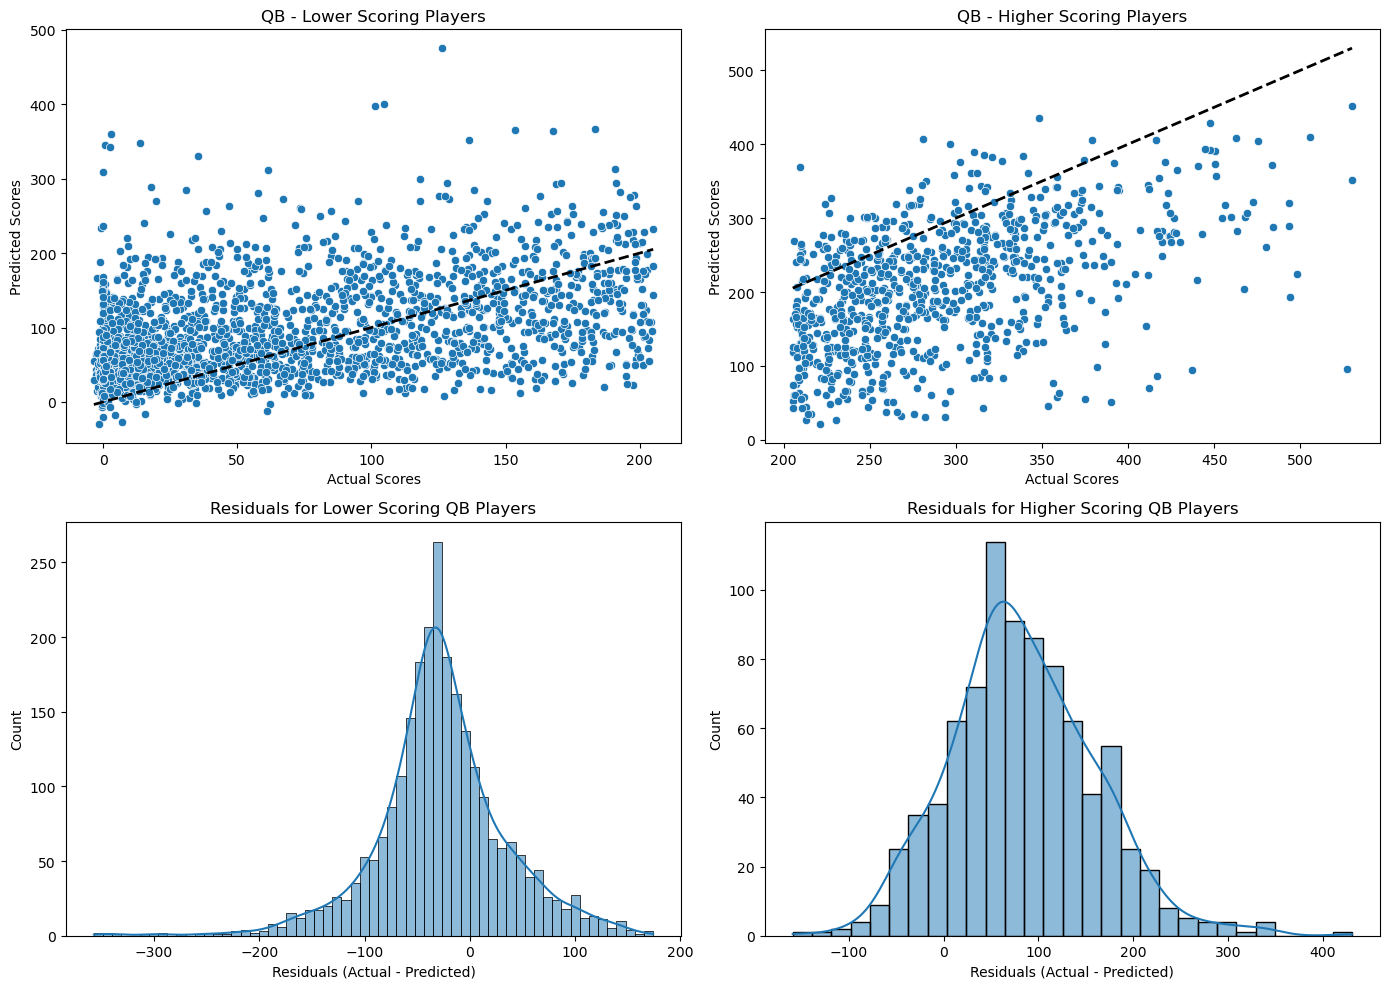

RB - Higher Scoring Players - RMSE: 85.05, R-squared: -0.86
RB - Lower Scoring Players - RMSE: 42.71, R-squared: -0.50


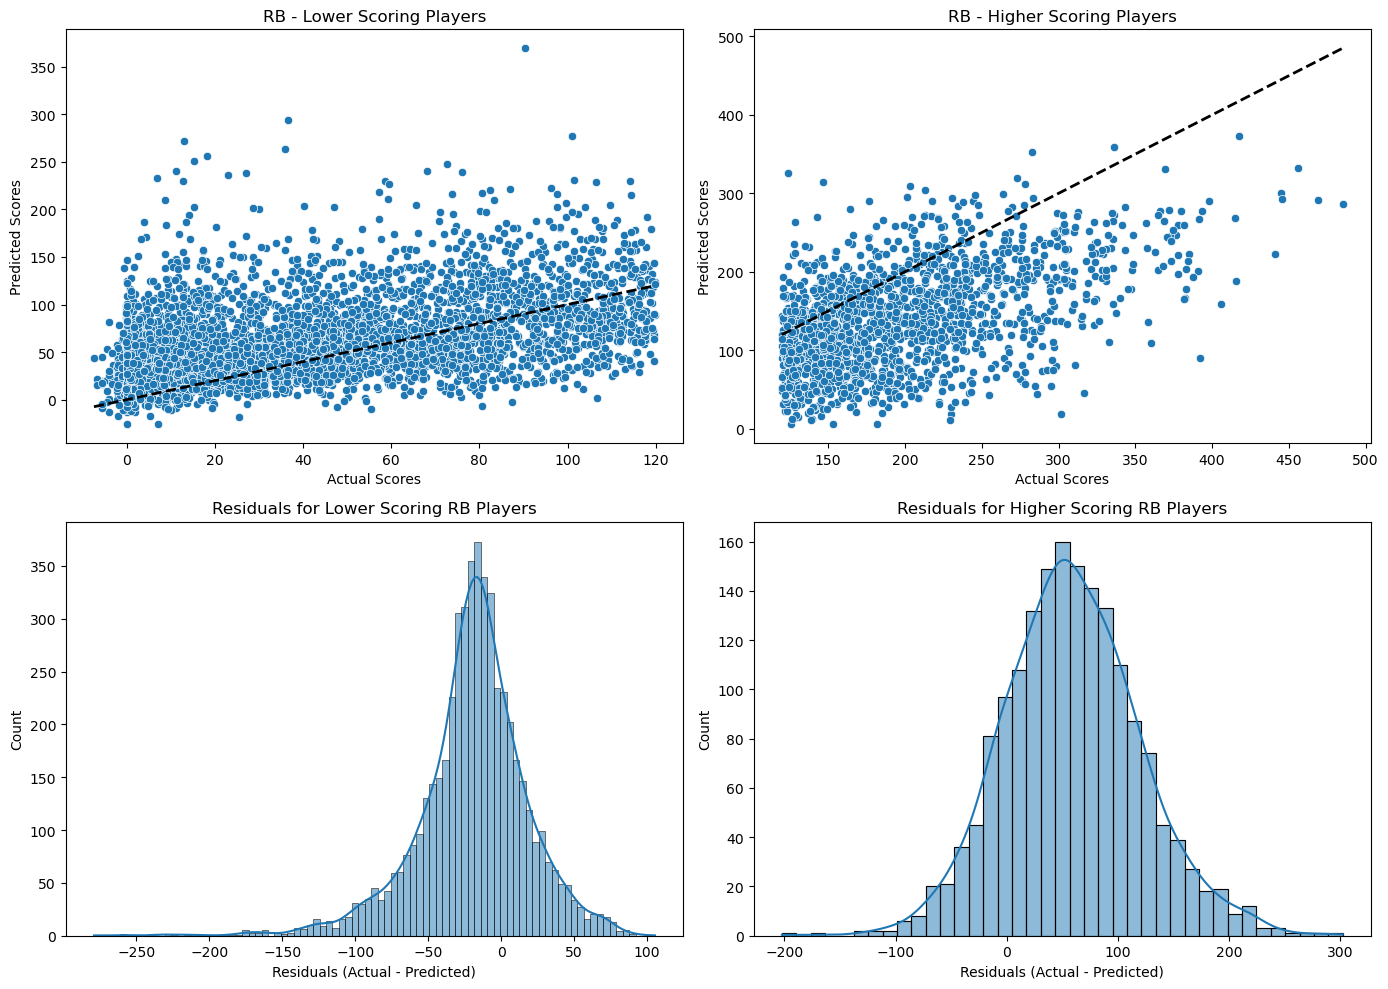

WR - Higher Scoring Players - RMSE: 77.86, R-squared: -1.36
WR - Lower Scoring Players - RMSE: 45.30, R-squared: -0.13


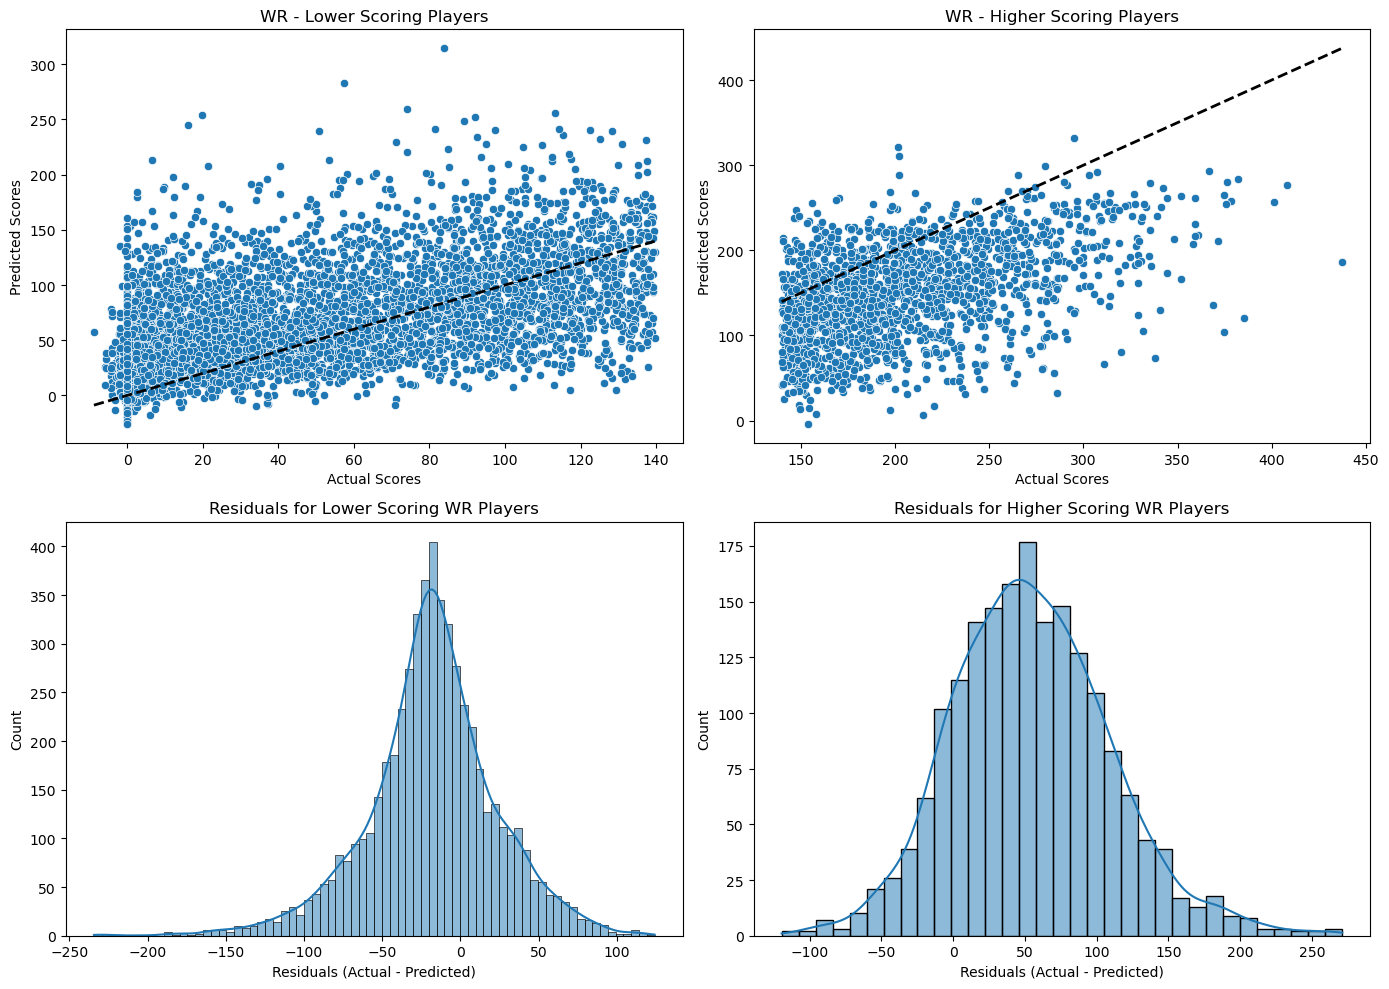

TE - Higher Scoring Players - RMSE: 58.82, R-squared: -0.62
TE - Lower Scoring Players - RMSE: 28.41, R-squared: -0.65


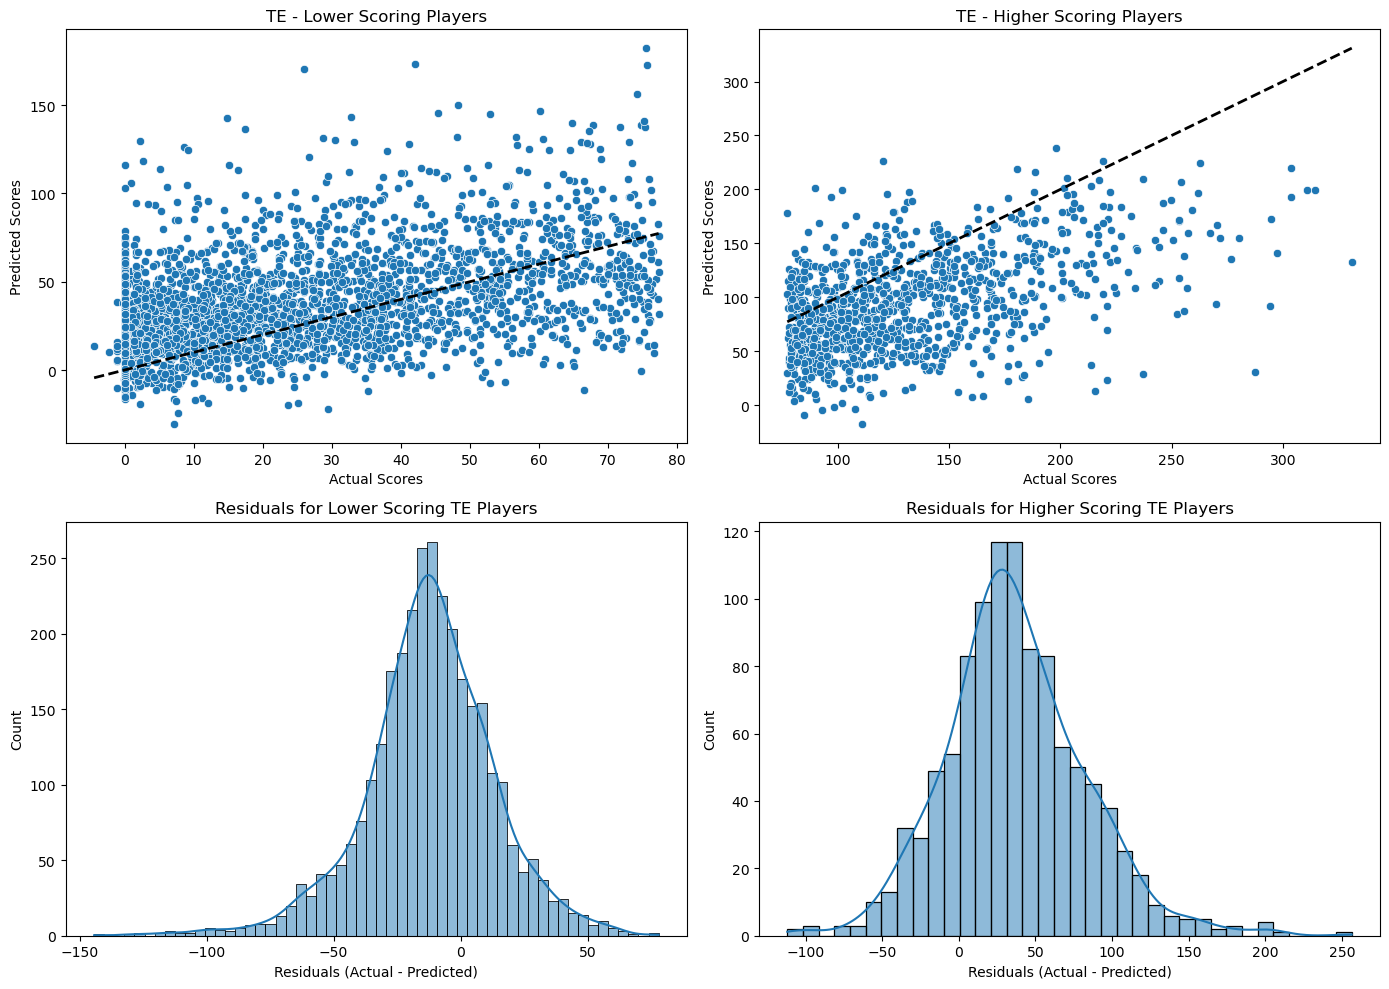

In [27]:
# Define column lists
id_cols = ['Key', 'Player', 'Year']
metadata_cols = ['Pos_QB', 'Pos_RB', 'Pos_TE', 'Pos_WR', 'Age', 'Exp', 'New_Team', 'AllPro']
aggregated_cols = ['Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_TD', 'Rec_Tgt', 'Rec_Rec', 'Rec_Yds', 'Rec_TD', 'FmbLost']
percentage_cols = ['games_played_pct', 'games_started_pct']

# features and target
X = model_1.drop(columns=id_cols + ['Target'])
y = model_1['Target']

# create pipeline
scaler = RobustScaler()
lr = LinearRegression()
pipeline = Pipeline([
    ('scaler', scaler),
    ('estimator', lr)
])

# Add predictions to the DataFrame
model_1['Prediction'] = cross_val_predict(pipeline, X, y, cv=5, n_jobs=-1)

# Add Target_rank and Prediction_rank columns
model_1['Target_rank'] = model_1.groupby(['Year', 'Pos_QB', 'Pos_RB', 'Pos_WR', 'Pos_TE'])['Target'].rank(ascending=False, method='min')
model_1['Prediction_rank'] = model_1.groupby(['Year', 'Pos_QB', 'Pos_RB', 'Pos_WR', 'Pos_TE'])['Prediction'].rank(ascending=False, method='min')

# Function to plot positional group
def plot_positional_group(position_df, position_name):
    # define threshold to get top 25% of players
    threshold = position_df['Target'].quantile(0.75)

    # Split the data into higher and lower scoring players
    higher_scoring = position_df[position_df['Target'] >= threshold]
    lower_scoring = position_df[position_df['Target'] < threshold]

    # Higher scoring players
    higher_rmse = mean_squared_error(higher_scoring['Target'], higher_scoring['Prediction'], squared=False)
    higher_r2 = r2_score(higher_scoring['Target'], higher_scoring['Prediction'])

    # Lower scoring players
    lower_rmse = mean_squared_error(lower_scoring['Target'], lower_scoring['Prediction'], squared=False)
    lower_r2 = r2_score(lower_scoring['Target'], lower_scoring['Prediction'])

    print(f'{position_name} - Higher Scoring Players - RMSE: {higher_rmse:.2f}, R-squared: {higher_r2:.2f}')
    print(f'{position_name} - Lower Scoring Players - RMSE: {lower_rmse:.2f}, R-squared: {lower_r2:.2f}')

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Scatter plot for lower scoring players
    sns.scatterplot(x=lower_scoring['Target'], y=lower_scoring['Prediction'], ax=axes[0, 0])
    axes[0, 0].plot([lower_scoring['Target'].min(), lower_scoring['Target'].max()], 
                    [lower_scoring['Target'].min(), lower_scoring['Target'].max()], 'k--', lw=2)
    axes[0, 0].set_title(f'{position_name} - Lower Scoring Players')
    axes[0, 0].set_xlabel('Actual Scores')
    axes[0, 0].set_ylabel('Predicted Scores')

    # Scatter plot for higher scoring players
    sns.scatterplot(x=higher_scoring['Target'], y=higher_scoring['Prediction'], ax=axes[0, 1])
    axes[0, 1].plot([higher_scoring['Target'].min(), higher_scoring['Target'].max()], 
                    [higher_scoring['Target'].min(), higher_scoring['Target'].max()], 'k--', lw=2)
    axes[0, 1].set_title(f'{position_name} - Higher Scoring Players')
    axes[0, 1].set_xlabel('Actual Scores')
    axes[0, 1].set_ylabel('Predicted Scores')

    # Distribution of residuals for lower scoring players
    sns.histplot(lower_scoring['Target'] - lower_scoring['Prediction'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'Residuals for Lower Scoring {position_name} Players')
    axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')

    # Distribution of residuals for higher scoring players
    sns.histplot(higher_scoring['Target'] - higher_scoring['Prediction'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Residuals for Higher Scoring {position_name} Players')
    axes[1, 1].set_xlabel('Residuals (Actual - Predicted)')

    plt.tight_layout()
    plt.show()

# Apply the function to each positional group
qb = model_1[model_1['Pos_QB'] == 1]
rb = model_1[model_1['Pos_RB'] == 1]
wr = model_1[model_1['Pos_WR'] == 1]
te = model_1[model_1['Pos_TE'] == 1]

plot_positional_group(qb, 'QB')
plot_positional_group(rb, 'RB')
plot_positional_group(wr, 'WR')
plot_positional_group(te, 'TE')


In [30]:

# Calculate rank difference
model_1['Rank_diff'] = model_1['Target_rank'] - model_1['Prediction_rank']

# Function to get top 10 players for each year and position based on actual and predicted ranks
def get_top_10_players(df, position_col):
    results = []

    for year in df['Year'].unique():
        pos_group = df[df[position_col] == 1]
        actual_top_10 = pos_group[pos_group['Year'] == year].nsmallest(10, 'Target_rank')
        predicted_top_10 = pos_group[pos_group['Year'] == year].nsmallest(10, 'Prediction_rank')

        results.append({
            'Year': year,
            'Position': position_col,
            'Actual_Top_10': actual_top_10[['Player', 'Target', 'Target_rank']].reset_index(drop=True),
            'Predicted_Top_10': predicted_top_10[['Player', 'Prediction', 'Prediction_rank']].reset_index(drop=True)
        })
    
    return results

# Apply the function to each positional group
qb_top_10 = get_top_10_players(model_1, 'Pos_QB')
rb_top_10 = get_top_10_players(model_1, 'Pos_RB')
wr_top_10 = get_top_10_players(model_1, 'Pos_WR')
te_top_10 = get_top_10_players(model_1, 'Pos_TE')

# Function to display the results
def display_top_10(results):
    for result in results:
        print(f"Year: {result['Year']}, Position: {result['Position']}")
        print("Actual Top 10:")
        print(result['Actual_Top_10'])
        print("\nPredicted Top 10:")
        print(result['Predicted_Top_10'])
        print("\n" + "="*50 + "\n")

# Display the results for each positional group
display_top_10(qb_top_10)
display_top_10(rb_top_10)
display_top_10(wr_top_10)
display_top_10(te_top_10)

Year: 2015, Position: Pos_QB
Actual Top 10:
             Player  Target  Target_rank
0     Aaron Rodgers  463.02          1.0
1         Matt Ryan  426.46          2.0
2        Drew Brees  421.32          3.0
3       Andrew Luck  378.70          4.0
4      Kirk Cousins  362.28          5.0
5     Philip Rivers  345.94          6.0
6  Matthew Stafford  335.78          7.0
7     Blake Bortles  329.10          8.0
8    Jameis Winston  324.10          9.0
9    Russell Wilson  321.06         10.0

Predicted Top 10:
             Player  Prediction  Prediction_rank
0    Russell Wilson  382.562291              1.0
1        Cam Newton  375.937762              2.0
2        Drew Brees  375.320235              3.0
3         Tom Brady  343.264669              4.0
4     Carson Palmer  316.738276              5.0
5     Blake Bortles  307.548205              6.0
6     Philip Rivers  296.926920              7.0
7  Matthew Stafford  293.413419              8.0
8       Andy Dalton  292.475213              

Use 2024 projection data, calculate VORP. 

In [ ]:
# load data
players_2023 = pd.read_csv('../data/final_data/players_2023.csv')